# Chicago Active Employee dataset study
Explanation and Key Steps:

1. Import Libraries: Standard data science stack.

1. Load Data: Reads the CSV. Includes a try-except for FileNotFoundError.

1. Initial Data Exploration:

  * df.info(): Data types, non-null counts.

  * df.head(): First few rows.

  * df.describe(): Statistical summary for numerical and object columns.

  * df.isnull().sum(): Counts missing values per column.

1. Data Cleaning and Preprocessing:

  * Column Names: Standardized to lowercase with underscores.

    * annual_salary: This is crucial. It's often an object type due to $ and commas. It's converted to a float. If not present, an attempt is made to calculate it from hourly_rate and typical_hours.

  * Drop NaNs/Zeros: Rows with no valid entries annual_salary are dropped as it's central to the analysis.

1. EDA - Visualizations:

  * Salary Distribution: Histogram and Boxplot to see its spread, skewness, and outliers.

  * Categorical Distributions: Countplots for full_or_part-time, salary_or_hourly.

  * Top Departments: Bar chart of departments with the most employees.

  * Salary by Employment Type/Department: Boxplots to see how salary varies across these categories.

1. Feature Engineering:

  * For Clustering:

    * Features: annual_salary and sex_encoded are selected.

    * Scaling: StandardScaler is used because K-Means is distance-based.

1. Clustering (K-Means):

  * Optimal K: Elbow Method (inertia vs. K) and Silhouette Score are used to help choose the number of clusters (k).

  * Model Training: K-Means is fitted with the chosen k.

  * Cluster Assignment: Cluster labels are added back to the DataFrame.

  * Analysis: Mean annual_salary and sex_encoded are calculated for each cluster.

  * Visualization: A scatter plot (if 2D) or strip/violin plot (if 1D) shows the clusters.


In [ ]:
!pip install pandas openpyxl

In [1]:
FILE_PATH='https://github.com/nluninja/chicago-active-employee-project/raw/refs/heads/main/City%20of%20Chicago%20Active%20Employees%20Dataset.xlsx'

Import the necessary libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, silhouette_score, roc_curve, auc
import warnings

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')



Load the dataset

In [3]:
try:
    df = pd.read_excel(FILE_PATH)
except FileNotFoundError:
    print("Dataset file not found. Please download it and place it in the correct path.")
    print("You can often find it by searching 'Current Employee Names, Salaries, and Position Titles Chicago'.")
    exit()

## EDA - Initial Data Exploration

In [4]:

df.head()

,Name,Job Titles,Department,Full or Part-Time,Salary or Hourly,Typical Hours,Annual Salary,Hourly Rate
0,"CABALLERO, SAMUEL A",FOREMAN OF MOTOR TRUCK DRIVERS,DEPT STREETS AND SANITATION,F,HOURLY,40.0,NaN,41.41
1,"CHAPMAN, BRYAN A",FIREFIGHTER-EMT (RECRUIT),FIRE DEPARTMENT,F,SALARY,NaN,80448.0,NaN
2,"MUNOZ, LISSETTE C",POLICE OFFICER,DEPARTMENT OF POLICE,F,SALARY,NaN,97974.0,NaN
3,"ALDERDEN, JACOB M",CAPTAIN,DEPARTMENT OF POLICE,F,SALARY,NaN,159552.0,NaN
4,"JOHNSON, ANTHONY L",MOTOR TRUCK DRIVER,DEPT OF WATER MANAGEMENT,F,HOURLY,40.0,NaN,39.25


In [5]:
print("--- Dataset Info ---")
print(df.info())

print("\n--- Basic Statistics (Numerical Columns) ---")
print(df.describe())

print("\n--- Missing Values ---")
print(df.isnull().sum())

--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30859 entries, 0 to 30858
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               30859 non-null  object 
 1   Job Titles         30859 non-null  object 
 2   Department         30859 non-null  object 
 3   Full or Part-Time  30857 non-null  object 
 4   Salary or Hourly   30859 non-null  object 
 5   Typical Hours      6634 non-null   float64
 6   Annual Salary      24225 non-null  float64
 7   Hourly Rate        6634 non-null   float64
dtypes: float64(3), object(5)
memory usage: 1.9+ MB
None

--- Basic Statistics (Numerical Columns) ---
       Typical Hours  Annual Salary  Hourly Rate
count    6634.000000   24225.000000  6634.000000
mean       36.823937   99666.742722    38.958197
std         7.751807   24355.736917    12.991061
min        10.000000   22248.000000     3.150000
25%        40.000000   85344.000000    32.1

## 1b Dataset Changes with the additional columns

let's try to add gender information using a standard library, gender-guesser.

In [6]:
!pip install gender-guesser

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 379.3/379.3 kB 6.0 MB/s eta 0:00:00


In [7]:
import pandas as pd
import gender_guesser.detector as gender # For gender inference

In [8]:
def add_name_sex_columns_df(df):
    """
    Adds Surname, First Name, and Sex columns to an existing Pandas DataFrame.

    Args:
        df (pd.DataFrame): DataFrame with at least a 'Name' column.

    Returns:
        pd.DataFrame: DataFrame with added 'Surname', 'First Name', and 'Sex' columns.
    """
    if 'Name' not in df.columns:
        raise ValueError("DataFrame must contain a 'Name' column.")

    gd = gender.Detector()

    # --- 1. Extract Surname and the rest of the name ---
    # Splitting 'Name' column by the first comma.
    # 'expand=True' creates new columns for each part of the split.
    # 'n=1' ensures we only split on the first comma.
    name_parts = df['Name'].str.split(',', n=1, expand=True)

    # Assign Surname (part before the comma)
    df['Surname'] = name_parts[0].str.strip()

    # --- 2. Extract First Name ---
    # The part after the comma (name_parts[1]) might contain first name and middle initials/suffixes.
    # We take the first word from this part as the 'First Name'.
    # .fillna('') handles cases where there might be no comma (though less likely with this dataset format)
    # or if the part after the comma is missing.
    df['First Name'] = name_parts[1].fillna('').str.strip().str.split(' ', n=1, expand=True)[0].str.strip()

    # Replace completely empty strings in 'First Name' with NaN (or pd.NA) if desired,
    # or keep as empty string if that's preferred. pd.NA is more idiomatic for missing data.
    df['First Name'] = df['First Name'].replace('', pd.NA)


    # --- 3. Infer Sex ---
    def get_sex(first_name_str):
        if pd.isna(first_name_str) or not str(first_name_str).strip():
            return "U"  # Unknown for NaN or empty names

        # Take only the first word of the first_name_str for gender guessing
        name_to_guess = str(first_name_str).strip().split(" ")[0]

        if not name_to_guess: # If after splitting, it's empty
             return "U"

        gender_raw = gd.get_gender(name_to_guess.capitalize())
        if gender_raw in ["male", "mostly_male"]:
            return "M"
        elif gender_raw in ["female", "mostly_female"]:
            return "F"
        elif gender_raw in ["andy"]: # Androgynous
             return "A" # Or "U" depending on your preference
        else: # "unknown" or other cases
            return "U"

    df['Sex'] = df['First Name'].apply(get_sex)

    return df


In [9]:
# Handle potential NaN values in 'Name' column if they exist from CSV import
df['Name'] = df['Name'].fillna('')

# 3. Process the DataFrame
employee_df_processed = add_name_sex_columns_df(df.copy()) # Use .copy() to avoid modifying the original df if needed



In [10]:
employee_df_processed.head(15)

,Name,Job Titles,Department,Full or Part-Time,Salary or Hourly,Typical Hours,Annual Salary,Hourly Rate,Surname,First Name,Sex
0,"CABALLERO, SAMUEL A",FOREMAN OF MOTOR TRUCK DRIVERS,DEPT STREETS AND SANITATION,F,HOURLY,40.0,NaN,41.41,CABALLERO,SAMUEL,M
1,"CHAPMAN, BRYAN A",FIREFIGHTER-EMT (RECRUIT),FIRE DEPARTMENT,F,SALARY,NaN,80448.0,NaN,CHAPMAN,BRYAN,M
2,"MUNOZ, LISSETTE C",POLICE OFFICER,DEPARTMENT OF POLICE,F,SALARY,NaN,97974.0,NaN,MUNOZ,LISSETTE,F
3,"ALDERDEN, JACOB M",CAPTAIN,DEPARTMENT OF POLICE,F,SALARY,NaN,159552.0,NaN,ALDERDEN,JACOB,M
4,"JOHNSON, ANTHONY L",MOTOR TRUCK DRIVER,DEPT OF WATER MANAGEMENT,F,HOURLY,40.0,NaN,39.25,JOHNSON,ANTHONY,M
5,"AUGUSTINE, LORI A",POLICE OFFICER,DEPARTMENT OF POLICE,F,SALARY,NaN,97974.0,NaN,AUGUSTINE,LORI,F
6,"SHALABI, MAJDI A",SERGEANT,DEPARTMENT OF POLICE,F,SALARY,NaN,133860.0,NaN,SHALABI,MAJDI,M
7,"KELLY, LUKE L",LIEUTENANT,DEPARTMENT OF POLICE,F,SALARY,NaN,150318.0,NaN,KELLY,LUKE,M
8,"FORSELL, JEREMIAH L",SERGEANT,DEPARTMENT OF POLICE,F,SALARY,NaN,129666.0,NaN,FORSELL,JEREMIAH,M
9,"SCHNOOR, KELLY A",LIEUTENANT,DEPARTMENT OF POLICE,F,SALARY,NaN,141552.0,NaN,SCHNOOR,KELLY,F


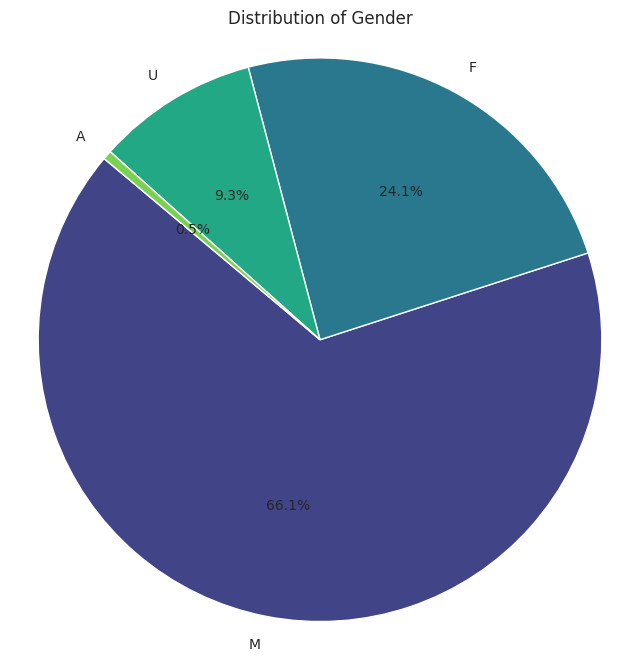

In [11]:
# Check if 'Sex' column exists before plotting
if 'Sex' in employee_df_processed.columns:
  plt.figure(figsize=(8, 8))
  # Count the occurrences of each unique value in the 'Sex' column
  gender_counts = employee_df_processed['Sex'].value_counts()

  # Create the pie chart
  plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('viridis', len(gender_counts)))
  plt.title('Distribution of Gender')
  plt.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
  plt.show()
else:
  print("'Sex' column not found in the DataFrame. Please ensure it is created.")

In [12]:
employee_df_processed[employee_df_processed['Sex'] == 'A']

,Name,Job Titles,Department,Full or Part-Time,Salary or Hourly,Typical Hours,Annual Salary,Hourly Rate,Surname,First Name,Sex
188,"STUCKIE, JO ANNE E",SENIOR DATA ENTRY OPERATOR,DEPARTMENT OF POLICE,F,SALARY,NaN,70860.0,NaN,STUCKIE,JO,A
232,"CHO, SEUNG H",SERGEANT,DEPARTMENT OF POLICE,F,SALARY,NaN,129666.0,NaN,CHO,SEUNG,A
359,"REYES JR, SANTOS T",SERGEANT,DEPARTMENT OF POLICE,F,SALARY,NaN,125634.0,NaN,REYES JR,SANTOS,A
458,"CHIU, LAI PING",STAFF ASST TO THE ALDERMAN,CITY COUNCIL,F,SALARY,NaN,53568.0,NaN,CHIU,LAI,A
581,"SMITH, CASEY A",POLICE OFFICER,DEPARTMENT OF POLICE,F,SALARY,NaN,79974.0,NaN,SMITH,CASEY,A
...,...,...,...,...,...,...,...,...,...,...,...
30053,"LIN, HUAN",POLICE OFFICER (ASSIGNED AS DETECTIVE),DEPARTMENT OF POLICE,F,SALARY,NaN,109704.0,NaN,LIN,HUAN,A
30302,"ALLEN, DOMINIQUE",POLICE OFFICER,DEPARTMENT OF POLICE,F,SALARY,NaN,97974.0,NaN,ALLEN,DOMINIQUE,A
30431,"LUCKETT, CASEY A",POLICE OFFICER,DEPARTMENT OF POLICE,F,SALARY,NaN,56040.0,NaN,LUCKETT,CASEY,A
30668,"YUAN, AN",POLICE OFFICER,DEPARTMENT OF POLICE,F,SALARY,NaN,97974.0,NaN,YUAN,AN,A


In [13]:
employee_df_processed[employee_df_processed['Sex'] == 'U']

,Name,Job Titles,Department,Full or Part-Time,Salary or Hourly,Typical Hours,Annual Salary,Hourly Rate,Surname,First Name,Sex
15,"ROSS, CORYANNE M",AMBULANCE COMMANDER,FIRE DEPARTMENT,F,SALARY,NaN,134736.0,NaN,ROSS,CORYANNE,U
16,"SWANAGAN, YOULANDA",FOREMAN OF PIPE / SALVAGE YARDS,DEPT OF WATER MANAGEMENT,F,HOURLY,40.0,NaN,47.00,SWANAGAN,YOULANDA,U
24,"CARR, ZERRICK B",MOTOR TRUCK DRIVER,CHICAGO PUBLIC LIBRARY,F,HOURLY,40.0,NaN,39.84,CARR,ZERRICK,U
26,"METOYER, FARLEY J",MOTOR TRUCK DRIVER,DEPT STREETS AND SANITATION,F,HOURLY,40.0,NaN,39.84,METOYER,FARLEY,U
31,"WATSON, SHALENA",GENERAL LABORER - DSS,DEPT STREETS AND SANITATION,F,HOURLY,40.0,NaN,24.46,WATSON,SHALENA,U
...,...,...,...,...,...,...,...,...,...,...,...
30748,"GRANADO, TONACIA",POLICE OFFICER,DEPARTMENT OF POLICE,F,SALARY,NaN,104934.0,NaN,GRANADO,TONACIA,U
30755,"OTERO, SELINET",POLICE OFFICER (ASSIGNED AS DETECTIVE),DEPARTMENT OF POLICE,F,SALARY,NaN,117690.0,NaN,OTERO,SELINET,U
30762,"QUIROZ, ZAUL",POLICE OFFICER,DEPARTMENT OF POLICE,F,SALARY,NaN,97974.0,NaN,QUIROZ,ZAUL,U
30769,"HATTEN, KATESA D",POLICE OFFICER,DEPARTMENT OF POLICE,F,SALARY,NaN,97974.0,NaN,HATTEN,KATESA,U


Too many Undedefined value: the guesser library doesn't have a great coverage for foreign names. Let's rely on first name generated lists.

In [36]:
import requests
import requests.exceptions

MALE_FILE = "https://github.com/nluninja/chicago-active-employee-project/raw/refs/heads/main/M.txt"
FEMALE_FILE = "https://github.com/nluninja/chicago-active-employee-project/raw/refs/heads/main/F.txt"
NEUTRAL_FILE = "https://github.com/nluninja/chicago-active-employee-project/raw/refs/heads/main/N.txt"

# Global sets to store names - loaded once for efficiency
MALE_NAMES = set()
FEMALE_NAMES = set()
NEUTRAL_NAMES = set()
NAMES_LOADED = False # Flag to check if names have been loaded

def _load_names_from_file(file_path):
    """Helper function to load names from a file into a set (lowercase)."""
    names = set()
    try:
        with requests.get(file_path) as f:
            lines = f.text.splitlines()
            for line in lines:
                names.add(line.strip().lower())
    except requests.exceptions.HTTPError as http_err:
        print(f"HTTP error occurred: {http_err} ")
    return names

def load_gender_name_lists(male_file, female_file, neutral_file):
    """Loads names from specified files into global sets."""
    global MALE_NAMES, FEMALE_NAMES, NEUTRAL_NAMES, NAMES_LOADED
    MALE_NAMES = _load_names_from_file(male_file)
    print(MALE_NAMES)
    FEMALE_NAMES = _load_names_from_file(female_file)
    NEUTRAL_NAMES = _load_names_from_file(neutral_file)
    NAMES_LOADED = True
    print(f"Loaded {len(MALE_NAMES)} male, {len(FEMALE_NAMES)} female, and {len(NEUTRAL_NAMES)} neutral names.")

def check_name_gender_from_files(first_name_str):
    """
    Checks if a name is Male, Female, or Neutral based on pre-loaded name lists.
    Returns 'M', 'F', 'N', or 'U' (Unknown).
    Assumes load_gender_name_lists() has been called.
    """
    if not NAMES_LOADED:
        # Or raise an error, or load them here if file paths are known globally
        print("Warning: Gender name lists have not been loaded. Call load_gender_name_lists() first.")
        return "U"

    if pd.isna(first_name_str) or not str(first_name_str).strip():
        return "U"

    # Take only the first word for checking, and convert to lowercase
    name_to_check = str(first_name_str).strip().split(" ")[0].lower()

    if not name_to_check:
        return "U"

    # Order of checking matters if names overlap in lists
    # You might adjust this priority based on your data.
    if name_to_check in MALE_NAMES:
        gender = "M"
    elif name_to_check in FEMALE_NAMES:
        gender = "F"
    elif name_to_check in NEUTRAL_NAMES:
        gender = "N"
    else:
        gender = "U"
    return gender

def add_name_sex_columns_df_custom_lists2(df, male_file, female_file, neutral_file):
    """
    Adds Surname, First Name, and Sex columns to an existing Pandas DataFrame
    using custom name lists for gender classification.

    Args:
        df (pd.DataFrame): DataFrame with at least a 'Name' column.
        male_file (str): Path to the text file containing male names.
        female_file (str): Path to the text file containing female names.
        neutral_file (str): Path to the text file containing neutral names.

    Returns:
        pd.DataFrame: DataFrame with added 'Surname', 'First Name', and 'Sex' columns.
    """
    if 'Name' not in df.columns:
        raise ValueError("DataFrame must contain a 'Name' column.")

    # Load name lists if not already loaded (or if you want to ensure fresh load)
    # For repeated calls with the same files, this could be optimized
    # by loading once outside this function.
    global NAMES_LOADED
    if not NAMES_LOADED: # Only load if they haven't been loaded yet
        load_gender_name_lists(male_file, female_file, neutral_file)

    # Ensure 'Name' column is string type and handle potential NaNs
    df['Name'] = df['Name'].astype(str).fillna('')

    # --- 1. Extract Surname ---
    name_parts = df['Name'].str.split(',', n=1, expand=True)
    df['Surname'] = name_parts[0].str.strip()

    # --- 2. Extract First Name ---
    first_name_series = name_parts.get(1, pd.Series(index=df.index, dtype=str)).fillna('').str.strip()
    df['First Name'] = first_name_series.str.split(' ', n=1, expand=True)[0].str.strip()
    df['First Name'] = df['First Name'].replace('', pd.NA)


    # --- 3. Infer Sex using custom lists ---
    df['Sex'] = df['First Name'].apply(check_name_gender_from_files)

    return df

In [37]:
employee_df2_processed = add_name_sex_columns_df_custom_lists2(
    df.copy(),
    MALE_FILE,
    FEMALE_FILE,
    NEUTRAL_FILE
)

print("\nProcessed DataFrame:")
print(employee_df2_processed)

print("\nEmployees with Sex = 'U':")
unknown_sex_df = employee_df2_processed[employee_df2_processed['Sex'] == 'U']
if unknown_sex_df.empty:
    print("No employees found with Sex = 'U'.")
else:
    print(unknown_sex_df[['Name', 'Surname', 'First Name', 'Sex']])

print("\nEmployees with Sex = 'N':")
neutral_sex_df = employee_df2_processed[employee_df2_processed['Sex'] == 'N']
if neutral_sex_df.empty:
    print("No employees found with Sex = 'N'.")
else:
    print(neutral_sex_df[['Name', 'Surname', 'First Name', 'Sex']])

{'demid', 'tashad', 'bouvier', 'rodny', 'browning', 'larry', 'keanon', 'sohrab', 'cohan', 'yll', 'forney', 'credell', 'truce', 'kazmere', 'kholten', 'kriztian', 'marcale', 'austan', 'devere', 'idriss', 'kashe', 'draydin', 'niklaus', 'saveliy', 'jashandeep', 'dewy', 'elishua', 'sparsh', 'jahmaal', 'aevin', 'krunal', 'benyamin', 'odas', 'alkeem', 'quesean', 'kierson', 'romey', 'deagen', 'shance', 'jayshaun', 'denzal', 'samuelle', 'dokota', 'murari', 'yaya', 'torray', 'kuno', 'xzekiel', 'randell', 'aashray', 'zymeer', 'romain', 'nehemiah', 'roldan', 'clete', 'syi', 'mattthew', 'johnthomas', 'tyrrell', 'nyjour', 'slaton', 'modaser', 'wyeth', 'fhernando', 'balraj', 'rudra', 'hail', 'suede', 'melbert', 'tamarious', 'jerami', 'ezren', 'trelen', 'cregg', 'sincer', 'kashun', 'norval', 'chavis', 'champion', 'bush', 'masonalexander', 'rashod', 'kruze', 'kasein', 'conall', 'hadi', 'stephens', 'grenville', 'ezekieo', 'jacinto', 'orestes', 'nyjah', 'khorey', 'izeck', 'josedaniel', 'gantt', 'ireneo',

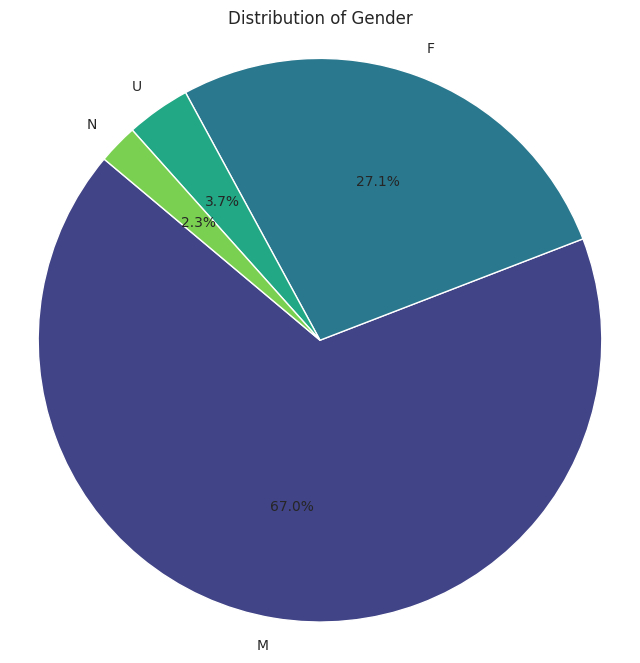

In [38]:
# Check if 'Sex' column exists before plotting
if 'Sex' in employee_df2_processed.columns:
  plt.figure(figsize=(8, 8))
  # Count the occurrences of each unique value in the 'Sex' column
  gender_counts = employee_df2_processed['Sex'].value_counts()

  # Create the pie chart
  plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('viridis', len(gender_counts)))
  plt.title('Distribution of Gender')
  plt.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
  plt.show()
else:
  print("'Sex' column not found in the DataFrame. Please ensure it is created.")

Some improvements, altough I was expecting something better. Let's focus on this data.

## 2. Data Cleaning and Preprocessing

Let's look at the columns. Common columns include:
'Name', 'Job Titles', 'Department', 'Full or Part-Time', 'Salary or Hourly', 'Typical Hours', 'Annual Salary', 'Hourly Rate'


In [39]:
df.head()

,Name,Job Titles,Department,Full or Part-Time,Salary or Hourly,Typical Hours,Annual Salary,Hourly Rate
0,"CABALLERO, SAMUEL A",FOREMAN OF MOTOR TRUCK DRIVERS,DEPT STREETS AND SANITATION,F,HOURLY,40.0,NaN,41.41
1,"CHAPMAN, BRYAN A",FIREFIGHTER-EMT (RECRUIT),FIRE DEPARTMENT,F,SALARY,NaN,80448.0,NaN
2,"MUNOZ, LISSETTE C",POLICE OFFICER,DEPARTMENT OF POLICE,F,SALARY,NaN,97974.0,NaN
3,"ALDERDEN, JACOB M",CAPTAIN,DEPARTMENT OF POLICE,F,SALARY,NaN,159552.0,NaN
4,"JOHNSON, ANTHONY L",MOTOR TRUCK DRIVER,DEPT OF WATER MANAGEMENT,F,HOURLY,40.0,NaN,39.25


In [40]:
df = employee_df2_processed

normalize columns

In [41]:
import re

# Define a function to normalize a single column name
def normalize_column_name(col_name):
    """
    Normalizes a column name by:
    1. Converting to lowercase.
    2. Stripping leading/trailing whitespace.
    3. Replacing spaces, hyphens, and other common separators with underscores.
    4. Removing any characters that are not alphanumeric or underscores.
    5. Consolidating multiple underscores into a single one.
    """
    name = str(col_name).lower()          # 1. Convert to lowercase (ensure it's a string first)
    name = name.strip()                   # 2. Remove leading/trailing whitespace
    name = re.sub(r'[\s-]+','_', name)   # 3. Replace spaces and hyphens with a single underscore
                                          #    r'[\s-]+' matches one or more whitespace characters or hyphens
    name = re.sub(r'[^a-z0-9_]+', '', name) # 4. Remove any character that is not a lowercase letter,
                                          #    a digit, or an underscore.
                                          #    r'[^a-z0-9_]+' matches one or more characters NOT in the set a-z, 0-9, _
    name = re.sub(r'_+', '_', name)       # 5. Consolidate multiple underscores (e.g., 'col__name' to 'col_name')
    return name

# Apply the normalization function to all column names using a list comprehension
df.columns = [normalize_column_name(col) for col in df.columns]

print("DataFrame with Normalized Column Names (Method 1):")
print(df.columns)

DataFrame with Normalized Column Names (Method 1):
Index(['name', 'job_titles', 'department', 'full_or_part_time',
       'salary_or_hourly', 'typical_hours', 'annual_salary', 'hourly_rate',
       'surname', 'first_name', 'sex'],
      dtype='object')


let's normalize the dataset computing the annual salary using the hour_rate, the number of worked hours, multiplying for 52 weeks

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30859 entries, 0 to 30858
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               30859 non-null  object 
 1   job_titles         30859 non-null  object 
 2   department         30859 non-null  object 
 3   full_or_part_time  30857 non-null  object 
 4   salary_or_hourly   30859 non-null  object 
 5   typical_hours      6634 non-null   float64
 6   annual_salary      24225 non-null  float64
 7   hourly_rate        6634 non-null   float64
 8   surname            30859 non-null  object 
 9   first_name         30859 non-null  object 
 10  sex                30859 non-null  object 
dtypes: float64(3), object(8)
memory usage: 2.6+ MB


In [43]:
mask_hourly = (df['salary_or_hourly'] == 'HOURLY')

calculated_values = df.loc[mask_hourly, 'hourly_rate'] * df.loc[mask_hourly, 'typical_hours'] * 52

# Assegna i valori calcolati alla colonna 'annual_salary' solo dove la maschera è True
df.loc[mask_hourly, 'annual_salary'] = calculated_values


In [44]:
df

,name,job_titles,department,full_or_part_time,salary_or_hourly,typical_hours,annual_salary,hourly_rate,surname,first_name,sex
0,"CABALLERO, SAMUEL A",FOREMAN OF MOTOR TRUCK DRIVERS,DEPT STREETS AND SANITATION,F,HOURLY,40.0,86132.8,41.41,CABALLERO,SAMUEL,M
1,"CHAPMAN, BRYAN A",FIREFIGHTER-EMT (RECRUIT),FIRE DEPARTMENT,F,SALARY,NaN,80448.0,NaN,CHAPMAN,BRYAN,M
2,"MUNOZ, LISSETTE C",POLICE OFFICER,DEPARTMENT OF POLICE,F,SALARY,NaN,97974.0,NaN,MUNOZ,LISSETTE,F
3,"ALDERDEN, JACOB M",CAPTAIN,DEPARTMENT OF POLICE,F,SALARY,NaN,159552.0,NaN,ALDERDEN,JACOB,M
4,"JOHNSON, ANTHONY L",MOTOR TRUCK DRIVER,DEPT OF WATER MANAGEMENT,F,HOURLY,40.0,81640.0,39.25,JOHNSON,ANTHONY,M
...,...,...,...,...,...,...,...,...,...,...,...
30854,"LADUZINSKY, MARK J",POLICE OFFICER,DEPARTMENT OF POLICE,F,SALARY,NaN,111966.0,NaN,LADUZINSKY,MARK,M
30855,"MARCIANO, DAVID",POLICE OFFICER,DEPARTMENT OF POLICE,F,SALARY,NaN,97974.0,NaN,MARCIANO,DAVID,M
30856,"CHORZEPA, PETER J",POLICE OFFICER,DEPARTMENT OF POLICE,F,SALARY,NaN,97974.0,NaN,CHORZEPA,PETER,M
30857,"SEPCOT, SEAN W",POLICE OFFICER,DEPARTMENT OF POLICE,F,SALARY,NaN,104934.0,NaN,SEPCOT,SEAN,M


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30859 entries, 0 to 30858
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               30859 non-null  object 
 1   job_titles         30859 non-null  object 
 2   department         30859 non-null  object 
 3   full_or_part_time  30857 non-null  object 
 4   salary_or_hourly   30859 non-null  object 
 5   typical_hours      6634 non-null   float64
 6   annual_salary      30859 non-null  float64
 7   hourly_rate        6634 non-null   float64
 8   surname            30859 non-null  object 
 9   first_name         30859 non-null  object 
 10  sex                30859 non-null  object 
dtypes: float64(3), object(8)
memory usage: 2.6+ MB


Something to fix about the full_or_part_time column  (why 308757?) let's investigate more.

In [46]:
df['full_or_part_time'].value_counts()


,count
full_or_part_time,
F,29878
P,979


In [47]:
df['full_or_part_time'].describe()


,full_or_part_time
count,30857
unique,2
top,F
freq,29878


In [48]:
df['full_or_part_time'].isna().sum()

np.int64(2)

we're going to remove the two rows with null values for.full_or_part_time

In [49]:
df.dropna(subset=['full_or_part_time'], inplace=True)

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30857 entries, 0 to 30858
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               30857 non-null  object 
 1   job_titles         30857 non-null  object 
 2   department         30857 non-null  object 
 3   full_or_part_time  30857 non-null  object 
 4   salary_or_hourly   30857 non-null  object 
 5   typical_hours      6633 non-null   float64
 6   annual_salary      30857 non-null  float64
 7   hourly_rate        6633 non-null   float64
 8   surname            30857 non-null  object 
 9   first_name         30857 non-null  object 
 10  sex                30857 non-null  object 
dtypes: float64(3), object(8)
memory usage: 2.8+ MB


at this point the dataset is usable for regression and clustering. I save the cleaned dataset for further references.


In [74]:
OUTPUT_FILE="chicago_dataset_cleaned.csv"
df.to_csv(OUTPUT_FILE)

Download it from [here](/content/chicago_dataset_cleaned.csv) .

## 3. Exploratory Data Analysis (EDA) - Visualizations


In [51]:
df['typical_hours'].value_counts()

,count
typical_hours,
40.0,5638
20.0,818
10.0,153
35.0,24


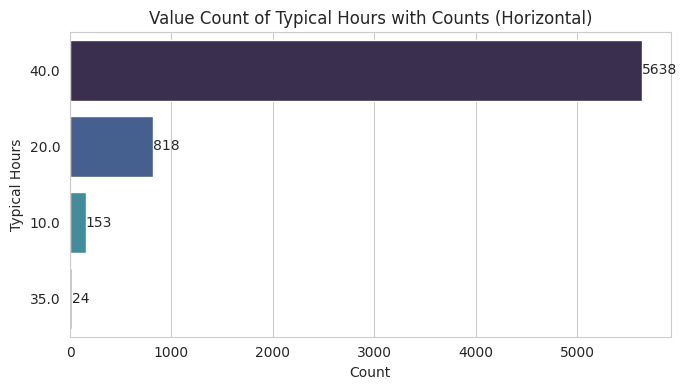

In [52]:
plt.figure(figsize=(7, 4))
ax = sns.countplot(data=df,
                   y='typical_hours',
                   order=df['typical_hours'].value_counts().index,
                   palette='mako')

plt.title('Value Count of Typical Hours with Counts (Horizontal)')
plt.xlabel('Count')
plt.ylabel('Typical Hours')

# Add text annotations for the counts on each bar
for p in ax.patches:
    width = p.get_width() # Get bar width (which is the count for horizontal)
    plt.text(width + 0.1, # X position of text (slightly offset from bar end)
             p.get_y() + p.get_height() / 2., # Y position of text (middle of the bar)
             f'{int(width)}', # The text to display (count as integer)
             va='center')     # Vertical alignment

plt.tight_layout()
plt.show()

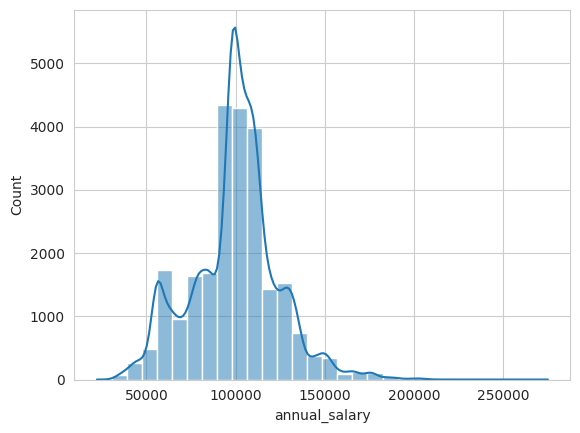

In [53]:
salary_data = df[df['salary_or_hourly'] == 'SALARY']

# Create a histogram of the annual salary rates
sns.histplot(data=salary_data, x='annual_salary', bins=30, kde=True)
plt.show()


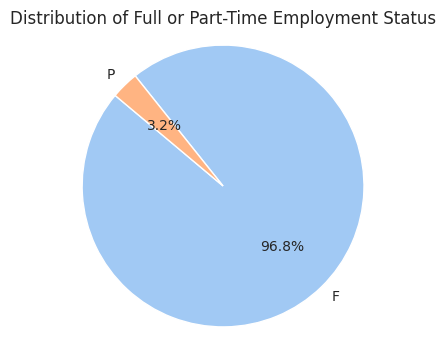

In [54]:
# Check if 'full_or_part-time' column exists
if 'full_or_part_time' in df.columns:
    plt.figure(figsize=(4, 4))
    # Count the occurrences of each unique value
    employment_type_counts = df['full_or_part_time'].value_counts().dropna()

    # Create the pie chart
    plt.pie(employment_type_counts, labels=employment_type_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel', len(employment_type_counts)))
    plt.title('Distribution of Full or Part-Time Employment Status')
    plt.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()
else:
    print("'full_or_part-time' column not found in the DataFrame.")

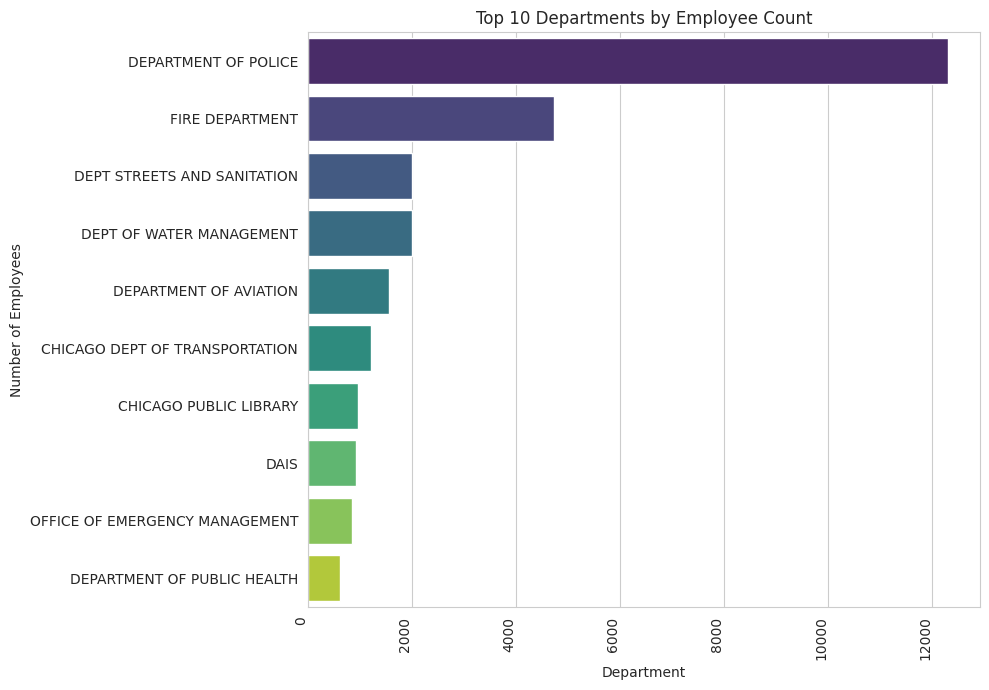

In [55]:

# Top 10 Departments by Employee Count
if 'department' in df.columns:
    plt.figure(figsize=(10, 7))
    top_departments = df['department'].value_counts().nlargest(10)
    sns.barplot(y=top_departments.index, x=top_departments.values, palette='viridis')
    plt.title('Top 10 Departments by Employee Count')
    plt.xlabel('Department')
    plt.ylabel('Number of Employees')
    plt.xticks(rotation=90, ha='right')
    plt.tight_layout()
    plt.show()

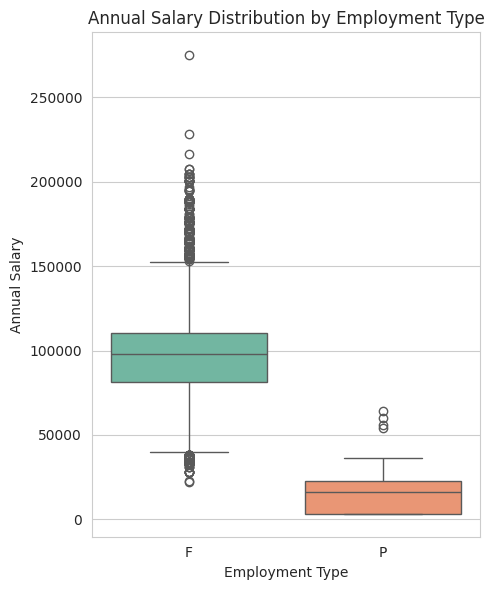

In [56]:
# Salary distribution by Full/Part-Time (if available)
if 'annual_salary' in df.columns and 'full_or_part_time' in df.columns:
    plt.figure(figsize=(5, 6))
    sns.boxplot(data=df, x='full_or_part_time', y='annual_salary', palette='Set2')
    plt.title('Annual Salary Distribution by Employment Type')
    plt.xlabel('Employment Type')
    plt.ylabel('Annual Salary')
    plt.ticklabel_format(style='plain', axis='y')
    plt.tight_layout()
    plt.show()

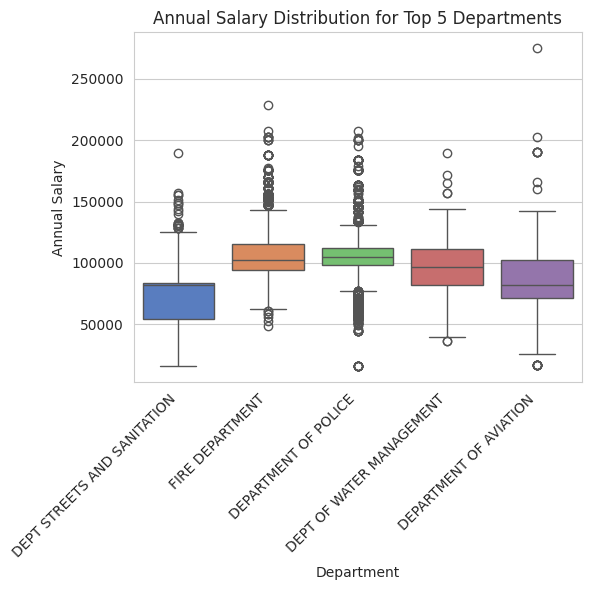

In [57]:
# Salary distribution by Top 5 Departments (if available)
if 'annual_salary' in df.columns and 'department' in df.columns:
    top_5_depts_list = top_departments.index[:5].tolist()
    df_top_depts = df[df['department'].isin(top_5_depts_list)]

    plt.figure(figsize=(6, 6))
    sns.boxplot(data=df_top_depts, x='department', y='annual_salary', palette='muted')
    plt.title('Annual Salary Distribution for Top 5 Departments')
    plt.xlabel('Department')
    plt.ylabel('Annual Salary')
    plt.xticks(rotation=45, ha='right')
    plt.ticklabel_format(style='plain', axis='y')
    plt.tight_layout()
    plt.show()

## 4. Feature Engineering for Models

For clustering, we'll primarily use 'annual_salary'. to use the 'Sex' column (with 'F', 'M', 'N' values) instead of 'typical_hours' for clustering, you'll need  to perform label encoding on the 'Sex' column because clustering algorithms typically work with numerical data.

For logistic regression, we'll predict if an employee is 'High Earner'.

In [58]:
sex_mapping = {'M': 0, 'F': 1, 'N': 2}

In [59]:
df['sex_encoded'] = df['sex'].map(sex_mapping)

In [60]:
df.head()

,name,job_titles,department,full_or_part_time,salary_or_hourly,typical_hours,annual_salary,hourly_rate,surname,first_name,sex,sex_encoded
0,"CABALLERO, SAMUEL A",FOREMAN OF MOTOR TRUCK DRIVERS,DEPT STREETS AND SANITATION,F,HOURLY,40.0,86132.8,41.41,CABALLERO,SAMUEL,M,0.0
1,"CHAPMAN, BRYAN A",FIREFIGHTER-EMT (RECRUIT),FIRE DEPARTMENT,F,SALARY,NaN,80448.0,NaN,CHAPMAN,BRYAN,M,0.0
2,"MUNOZ, LISSETTE C",POLICE OFFICER,DEPARTMENT OF POLICE,F,SALARY,NaN,97974.0,NaN,MUNOZ,LISSETTE,F,1.0
3,"ALDERDEN, JACOB M",CAPTAIN,DEPARTMENT OF POLICE,F,SALARY,NaN,159552.0,NaN,ALDERDEN,JACOB,M,0.0
4,"JOHNSON, ANTHONY L",MOTOR TRUCK DRIVER,DEPT OF WATER MANAGEMENT,F,HOURLY,40.0,81640.0,39.25,JOHNSON,ANTHONY,M,0.0


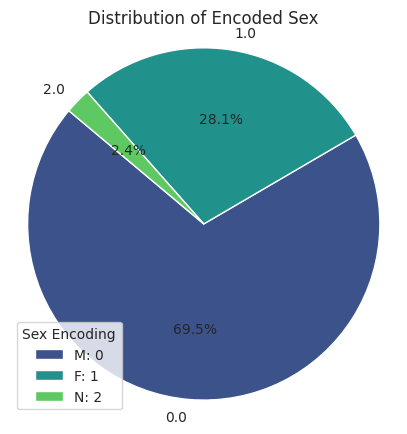

In [61]:

if 'sex_encoded' in df.columns:
    plt.figure(figsize=(5, 5))
    # Count the occurrences of each unique value in the 'sex_encoded' column
    sex_counts = df['sex_encoded'].value_counts().dropna()

    # Create the pie chart
    plt.pie(sex_counts, labels=sex_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('viridis', len(sex_counts)))
    plt.title('Distribution of Encoded Sex')
    plt.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.legend(title="Sex Encoding", labels=[f"{key}: {value}" for key, value in sex_mapping.items()])
    plt.show()
else:
    print("'sex_encoded' column not found in the DataFrame. Please ensure it is created.")

In [63]:
# Define features for clustering
features_for_clustering = ['annual_salary', 'sex_encoded']

X_cluster = df[features_for_clustering].copy()


## 5. Clustering (K-Means)


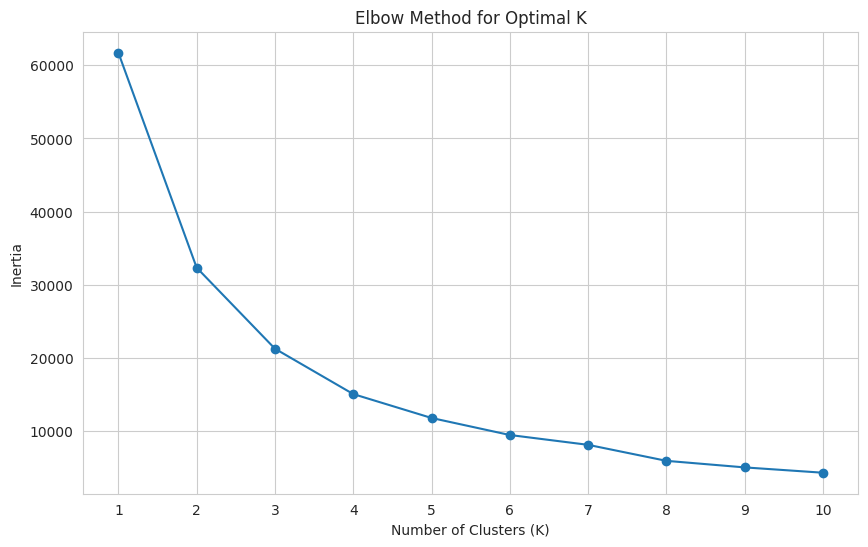

In [64]:
from sklearn.impute import SimpleImputer

# Handle missing values in X_cluster before scaling
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X_cluster_imputed = imputer.fit_transform(X_cluster)

# Scale these features
scaler_cluster = StandardScaler()
X_cluster_scaled = scaler_cluster.fit_transform(X_cluster_imputed)

# Determine optimal K using Elbow Method
inertia = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X_cluster_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.xticks(k_range)
plt.show()

For k=2, Silhouette Score: 0.5672
For k=3, Silhouette Score: 0.5749
For k=4, Silhouette Score: 0.5389
For k=5, Silhouette Score: 0.4832
For k=6, Silhouette Score: 0.5399
For k=7, Silhouette Score: 0.5116
For k=8, Silhouette Score: 0.5175
For k=9, Silhouette Score: 0.5119
For k=10, Silhouette Score: 0.5294


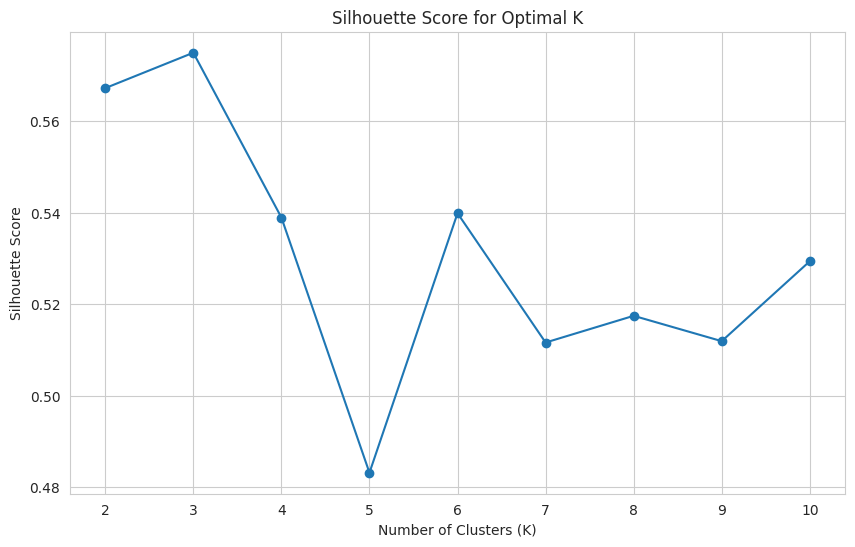


--- Cluster Analysis (K=3) ---
         annual_salary  sex_encoded
cluster                            
0         47361.682946     0.460598
1        105385.100838     0.000000
2         97967.386635     1.095927


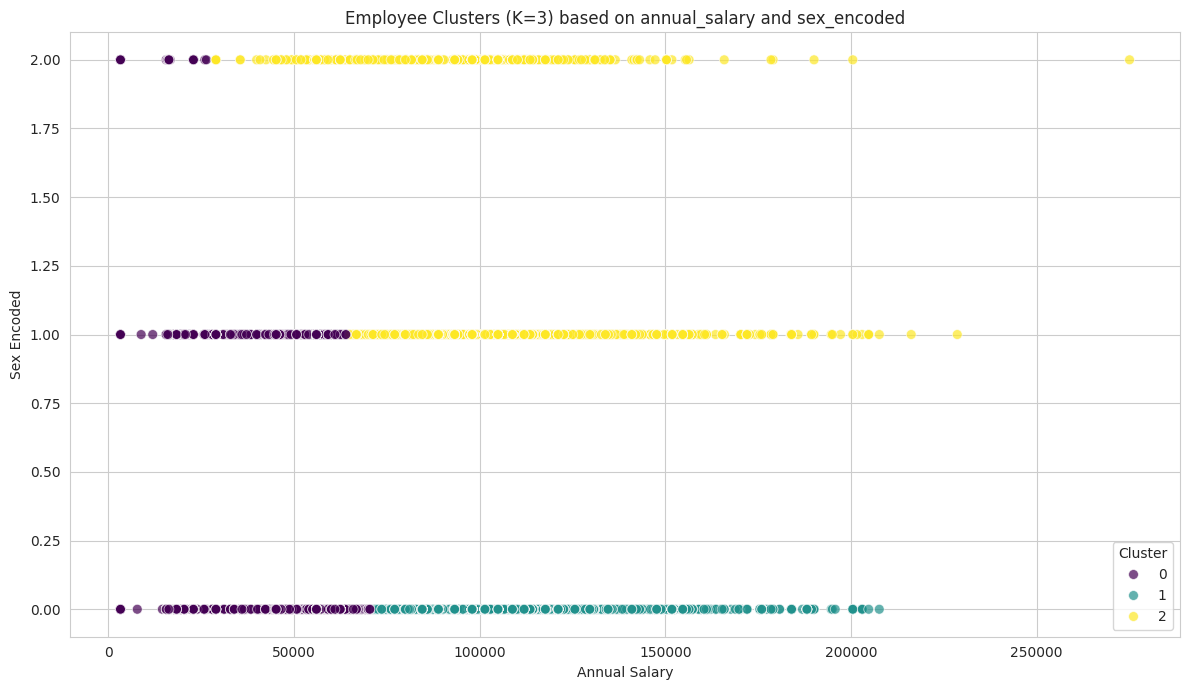

In [65]:
    # Determine optimal K using Silhouette Score
    silhouette_scores = []
    # Silhouette score is not defined for k=1
    k_range_silhouette = range(2, 11)
    for k in k_range_silhouette:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
        cluster_labels = kmeans.fit_predict(X_cluster_scaled)
        silhouette_avg = silhouette_score(X_cluster_scaled, cluster_labels)
        silhouette_scores.append(silhouette_avg)
        print(f"For k={k}, Silhouette Score: {silhouette_avg:.4f}")

    plt.figure(figsize=(10, 6))
    plt.plot(k_range_silhouette, silhouette_scores, marker='o')
    plt.title('Silhouette Score for Optimal K')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Silhouette Score')
    plt.xticks(k_range_silhouette)
    plt.show()

    # Based on Elbow and Silhouette, choose K (e.g., K=3 or 4)
    # Let's pick K=3 for this example, adjust based on your plots
    optimal_k = 3
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
    df['cluster'] = kmeans.fit_predict(X_cluster_scaled)

    # Analyze clusters
    print(f"\n--- Cluster Analysis (K={optimal_k}) ---")
    cluster_summary = df.groupby('cluster')[features_for_clustering].mean()
    print(cluster_summary)

    # Visualize clusters
    plt.figure(figsize=(12, 7))
    if len(features_for_clustering) > 1:
        sns.scatterplot(data=df, x=features_for_clustering[0], y=features_for_clustering[1], hue='cluster', palette='viridis', s=50, alpha=0.7)
        plt.title(f'Employee Clusters (K={optimal_k}) based on {features_for_clustering[0]} and {features_for_clustering[1]}')
        plt.xlabel(features_for_clustering[0].replace('_', ' ').title())
        plt.ylabel(features_for_clustering[1].replace('_', ' ').title())
    else: # 1D clustering
        # For 1D, a swarm plot or violin plot per cluster might be better
        sns.stripplot(data=df, x='cluster', y=features_for_clustering[0], palette='viridis', jitter=0.35)
        plt.title(f'Employee Clusters (K={optimal_k}) based on {features_for_clustering[0]}')
        plt.xlabel('Cluster')
        plt.ylabel(features_for_clustering[0].replace('_', ' ').title())

    plt.ticklabel_format(style='plain', axis='y')
    plt.ticklabel_format(style='plain', axis='x')
    plt.legend(title='Cluster')
    plt.tight_layout()
    plt.show()

## 7. Logistic Regression for Classification

* Goal 1: Predicting sex_encoded (Gender Proxy)
* Target Variable: sex_encoded (with values 0, 1, 2)
* Type of Logistic Regression: Multinomial Logistic
* Regression (since there are 3 categories).
* Objective: To build a model that uses other employee attributes (like Job Title, Department, Salary, Hours, etc.) to predict the sex_encoded category of an employee.
* Question it answers: What employee characteristics are associated with the different sex_encoded categories?

In [77]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer # For handling potential NaNs in features

In [78]:
df.head()

,name,job_titles,department,full_or_part_time,salary_or_hourly,typical_hours,annual_salary,hourly_rate,surname,first_name,sex,sex_encoded,cluster
0,"CABALLERO, SAMUEL A",FOREMAN OF MOTOR TRUCK DRIVERS,DEPT STREETS AND SANITATION,F,HOURLY,40.0,86132.8,41.41,CABALLERO,SAMUEL,M,0.0,1
1,"CHAPMAN, BRYAN A",FIREFIGHTER-EMT (RECRUIT),FIRE DEPARTMENT,F,SALARY,NaN,80448.0,NaN,CHAPMAN,BRYAN,M,0.0,1
2,"MUNOZ, LISSETTE C",POLICE OFFICER,DEPARTMENT OF POLICE,F,SALARY,NaN,97974.0,NaN,MUNOZ,LISSETTE,F,1.0,2
3,"ALDERDEN, JACOB M",CAPTAIN,DEPARTMENT OF POLICE,F,SALARY,NaN,159552.0,NaN,ALDERDEN,JACOB,M,0.0,1
4,"JOHNSON, ANTHONY L",MOTOR TRUCK DRIVER,DEPT OF WATER MANAGEMENT,F,HOURLY,40.0,81640.0,39.25,JOHNSON,ANTHONY,M,0.0,1


Value Counts for Target Variable 'sex_encoded'

In [79]:
df['sex_encoded'].value_counts()

,count
sex_encoded,
0.0,20663
1.0,8351
2.0,705


We assume 'name, surname, first name, sex' are not a predictive feature.
We remove the columns for hourly_rate and typical hours as they are not available for all the datapoints

In [80]:
y = df['sex_encoded']

In [81]:
y.shape

(30857,)

In [85]:
# Columns to remove from X
cols_to_remove_from_X = [
    'name', 'surname', 'first_name', 'sex',  # Name and direct sex identifiers
    'typical_hours', 'hourly_rate', 'cluster',         # Specified for removal
    'sex_encoded'                           # Target variable itself
]

In [86]:
X = df.drop(columns=cols_to_remove_from_X, errors='ignore')


In [87]:
print("\n--- Features (X) sample after dropping columns ---")
print(X.head())
print(f"\nShape of X: {X.shape}")
print(f"\nColumns remaining in X: {X.columns.tolist()}")


--- Features (X) sample after dropping columns ---
                       job_titles                   department  \
0  FOREMAN OF MOTOR TRUCK DRIVERS  DEPT STREETS AND SANITATION   
1       FIREFIGHTER-EMT (RECRUIT)              FIRE DEPARTMENT   
2                  POLICE OFFICER         DEPARTMENT OF POLICE   
3                         CAPTAIN         DEPARTMENT OF POLICE   
4              MOTOR TRUCK DRIVER     DEPT OF WATER MANAGEMENT   

  full_or_part_time salary_or_hourly  annual_salary  
0                 F           HOURLY        86132.8  
1                 F           SALARY        80448.0  
2                 F           SALARY        97974.0  
3                 F           SALARY       159552.0  
4                 F           HOURLY        81640.0  

Shape of X: (30857, 5)

Columns remaining in X: ['job_titles', 'department', 'full_or_part_time', 'salary_or_hourly', 'annual_salary']


In [88]:
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()

print(f"\nNumerical Features for X: {numerical_features}")
print(f"Categorical Features for X: {categorical_features}")


Numerical Features for X: ['annual_salary']
Categorical Features for X: ['job_titles', 'department', 'full_or_part_time', 'salary_or_hourly']



Create transformers
For numerical features: Impute NaNs (e.g., with median) then Standardize; For categorical features: Impute NaNs (e.g., with most frequent) then One-hot encode


In [89]:

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # Handle NaNs in numerical cols (e.g., annual_salary)
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # Handle NaNs in categorical cols
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False))
])

# Create a preprocessor object using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' # If any columns are missed by selector, pass them (shouldn't happen here)
)

In [91]:
# Drop rows where the target variable 'y' is NaN
df.dropna(subset=['sex_encoded'], inplace=True)
y = df['sex_encoded']
X = df.drop(columns=cols_to_remove_from_X, errors='ignore')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

stratify=y: Ensures that the proportion of each class in sex_encoded is roughly the same in both the training and testing sets. This is important for imbalanced datasets.

In [92]:
print(f"\nTraining set shape: X_train-{X_train.shape}, y_train-{y_train.shape}")
print(f"Test set shape: X_test-{X_test.shape}, y_test-{y_test.shape}")
print("\nTest set 'sex_encoded' distribution:")
print(y_test.value_counts(normalize=True))


Training set shape: X_train-(22289, 5), y_train-(22289,)
Test set shape: X_test-(7430, 5), y_test-(7430,)

Test set 'sex_encoded' distribution:
sex_encoded
0.0    0.695289
1.0    0.281023
2.0    0.023688
Name: proportion, dtype: float64


Create a pipeline with preprocessing and logistic regression
 `multi_class='auto'` will detect if it's binary or multinomial.
 If multinomial, it often uses 'ovr' (One-vs-Rest) by default for some solvers, or 'multinomial' for solvers like 'lbfgs', 'newton-cg', 'saga'.

 'solver='lbfgs'' is a common default for multinomial problems.

 'max_iter' might need adjustment for convergence on some datasets.

In [94]:
logreg_model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='lbfgs',
                                      multi_class='auto', # Detects multinomial based on y
                                      class_weight='balanced', # Useful for imbalanced classes
                                      random_state=42,
                                      max_iter=1000)) # Increased for potential convergence
])


Train the model

In [95]:

print("\nTraining the logistic regression model...")
logreg_model_pipeline.fit(X_train, y_train)
print("Model training complete.")


Training the logistic regression model...
Model training complete.


Make Predictions

In [96]:
y_pred_train = logreg_model_pipeline.predict(X_train)
y_pred_test = logreg_model_pipeline.predict(X_test)

In [97]:
print("\n--- Training Set Evaluation ---")
print(f"Accuracy: {accuracy_score(y_train, y_pred_train):.4f}")
print("Classification Report:\n", classification_report(y_train, y_pred_train, zero_division=0, target_names=[f'Class {i}' for i in sorted(y_train.unique())]))


--- Training Set Evaluation ---
Accuracy: 0.6611
Classification Report:
               precision    recall  f1-score   support

   Class 0.0       0.82      0.72      0.77     15497
   Class 1.0       0.57      0.53      0.55      6263
   Class 2.0       0.07      0.38      0.12       529

    accuracy                           0.66     22289
   macro avg       0.49      0.55      0.48     22289
weighted avg       0.73      0.66      0.69     22289



In [98]:
print("\n--- Test Set Evaluation ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_test):.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_test))
print("Classification Report:\n", classification_report(y_test, y_pred_test, zero_division=0, target_names=[f'Class {i}' for i in sorted(y_test.unique())]))


--- Test Set Evaluation ---
Accuracy: 0.6559
Confusion Matrix:
 [[3769  761  636]
 [ 753 1068  267]
 [  90   50   36]]
Classification Report:
               precision    recall  f1-score   support

   Class 0.0       0.82      0.73      0.77      5166
   Class 1.0       0.57      0.51      0.54      2088
   Class 2.0       0.04      0.20      0.06       176

    accuracy                           0.66      7430
   macro avg       0.47      0.48      0.46      7430
weighted avg       0.73      0.66      0.69      7430



## 8. Logistic Regression for Prediction

Predicting is_top_earner (Earning Status)
* Target Variable: is_top_earner (binary: 1 if they are a top earner, 0 if not). This was derived from Annual Salary.
* Type of Logistic Regression: Binary Logistic Regression.
* Objective: To build a model that uses other employee attributes (like Job Title, Department, Full/Part-Time, sex_encoded, etc. – excluding the direct salary figures used to define is_top_earner) to predict whether an employee is a top earner.

Question it answers: What employee characteristics are associated with being a top earner?

In [99]:
df.head()

,name,job_titles,department,full_or_part_time,salary_or_hourly,typical_hours,annual_salary,hourly_rate,surname,first_name,sex,sex_encoded,cluster
0,"CABALLERO, SAMUEL A",FOREMAN OF MOTOR TRUCK DRIVERS,DEPT STREETS AND SANITATION,F,HOURLY,40.0,86132.8,41.41,CABALLERO,SAMUEL,M,0.0,1
1,"CHAPMAN, BRYAN A",FIREFIGHTER-EMT (RECRUIT),FIRE DEPARTMENT,F,SALARY,NaN,80448.0,NaN,CHAPMAN,BRYAN,M,0.0,1
2,"MUNOZ, LISSETTE C",POLICE OFFICER,DEPARTMENT OF POLICE,F,SALARY,NaN,97974.0,NaN,MUNOZ,LISSETTE,F,1.0,2
3,"ALDERDEN, JACOB M",CAPTAIN,DEPARTMENT OF POLICE,F,SALARY,NaN,159552.0,NaN,ALDERDEN,JACOB,M,0.0,1
4,"JOHNSON, ANTHONY L",MOTOR TRUCK DRIVER,DEPT OF WATER MANAGEMENT,F,HOURLY,40.0,81640.0,39.25,JOHNSON,ANTHONY,M,0.0,1


Feature Engineering: Create Target Variable 'is_top_earner'


In [100]:
# Create 'Comparable Annual Salary'
# Fill NaNs that might arise from coercion or original data
df['annual_salary'] = df['annual_salary'].fillna(0)
df['hourly_rate'] = df['hourly_rate'].fillna(0)
df['typical_hours'] = df['typical_hours'].fillna(0) # Or a standard like 40 if appropriate

def calculate_comparable_salary(row):
    if row['salary_or_hourly'] == 'SALARY': # Case-insensitive check might be better
        return row['annual_salary']
    elif row['salary_or_hourly'] == 'HOURLY':
        return row['hourly_rate'] * row['typical_hours'] * 52 # Assuming 52 weeks
    return 0

df['Comparable Annual Salary'] = df.apply(calculate_comparable_salary, axis=1)

Define "top earner" - e.g., top 25% (75th percentile)

In [101]:
# Only consider non-zero salaries for percentile calculation
non_zero_salaries = df[df['Comparable Annual Salary'] > 0]['Comparable Annual Salary']
if not non_zero_salaries.empty:
    top_earner_threshold = non_zero_salaries.quantile(0.75) # Top 25%
else:
    print("Warning: No positive comparable salaries found. Setting threshold to infinity.")
    top_earner_threshold = np.inf

df['is_top_earner'] = (df['Comparable Annual Salary'] >= top_earner_threshold).astype(int)
y = df['is_top_earner'] # Our target variable

print(f"--- Top Earner Threshold (75th percentile): ${top_earner_threshold:,.2f} ---")
print("\n--- Value Counts for Target Variable 'is_top_earner' ---")
print(y.value_counts(normalize=True))

--- Top Earner Threshold (75th percentile): $110,178.00 ---

--- Value Counts for Target Variable 'is_top_earner' ---
is_top_earner
0    0.7473
1    0.2527
Name: proportion, dtype: float64


Columns to remove from features:
* Identifiers: 'name', 'surname', 'first_name'
* Direct sex indicator: 'sex' (we'll use 'sex_encoded' as a feature if available)

Columns used to define the target or highly correlated:
* 'annual_salary', 'hourly_rate', 'typical_hours', 'Comparable Annual Salary'
* The target itself: 'is_top_earner'

In [102]:


cols_to_remove_from_X = [
    'name', 'surname', 'first_name', 'sex',
    'annual_salary', 'hourly_rate', 'typical_hours', 'Comparable Annual Salary',
    'is_top_earner', # Target
    'cluster'        # Explicitly remove
]

X = df.drop(columns=cols_to_remove_from_X, errors='ignore')

# Ensure 'sex_encoded' (if present and intended as a feature) is cleaned
if 'sex_encoded' in X.columns:
    X['sex_encoded'] = pd.to_numeric(X['sex_encoded'], errors='coerce').fillna(X['sex_encoded'].mode()[0]).astype(int)
else:
    print("Warning: 'sex_encoded' column not found in X. It will not be used as a feature.")


print("\n--- Features (X) sample after dropping columns ---")
print(X.head())
print(f"\nShape of X: {X.shape}")
print(f"\nColumns remaining in X: {X.columns.tolist()}")



--- Features (X) sample after dropping columns ---
                       job_titles                   department  \
0  FOREMAN OF MOTOR TRUCK DRIVERS  DEPT STREETS AND SANITATION   
1       FIREFIGHTER-EMT (RECRUIT)              FIRE DEPARTMENT   
2                  POLICE OFFICER         DEPARTMENT OF POLICE   
3                         CAPTAIN         DEPARTMENT OF POLICE   
4              MOTOR TRUCK DRIVER     DEPT OF WATER MANAGEMENT   

  full_or_part_time salary_or_hourly  sex_encoded  
0                 F           HOURLY            0  
1                 F           SALARY            0  
2                 F           SALARY            1  
3                 F           SALARY            0  
4                 F           HOURLY            0  

Shape of X: (29719, 5)

Columns remaining in X: ['job_titles', 'department', 'full_or_part_time', 'salary_or_hourly', 'sex_encoded']


In [103]:
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()

print(f"\nNumerical Features for X: {numerical_features}") # 'sex_encoded' will be here if numeric
print(f"Categorical Features for X: {categorical_features}")



Numerical Features for X: ['sex_encoded']
Categorical Features for X: ['job_titles', 'department', 'full_or_part_time', 'salary_or_hourly']


In [104]:
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)


In [105]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

print(f"\nTraining set shape: X_train-{X_train.shape}, y_train-{y_train.shape}")
print(f"Test set shape: X_test-{X_test.shape}, y_test-{y_test.shape}")


Training set shape: X_train-(22289, 5), y_train-(22289,)
Test set shape: X_test-(7430, 5), y_test-(7430,)


In [106]:
logreg_model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear', # Good for binary, often handles L1/L2
                                      class_weight='balanced', # Handles imbalanced classes
                                      random_state=42,
                                      max_iter=1000))
])

print("\nTraining the logistic regression model for 'is_top_earner'...")
logreg_model_pipeline.fit(X_train, y_train)
print("Model training complete.")


Training the logistic regression model for 'is_top_earner'...
Model training complete.


In [107]:
y_pred_train = logreg_model_pipeline.predict(X_train)
y_pred_test = logreg_model_pipeline.predict(X_test)
y_pred_proba_test = logreg_model_pipeline.predict_proba(X_test)[:, 1] # Probabilities for the positive class (top earner)

In [110]:
print("\n--- Training Set Evaluation (Top Earner) ---")
print(f"Accuracy: {accuracy_score(y_train, y_pred_train):.4f}")
print("Classification Report:\n", classification_report(y_train, y_pred_train, zero_division=0, target_names=['Not Top Earner', 'Top Earner']))




--- Training Set Evaluation (Top Earner) ---
Accuracy: 0.9300
Classification Report:
                 precision    recall  f1-score   support

Not Top Earner       0.96      0.95      0.95     16657
    Top Earner       0.86      0.87      0.86      5632

      accuracy                           0.93     22289
     macro avg       0.91      0.91      0.91     22289
  weighted avg       0.93      0.93      0.93     22289



In [111]:
print("\n--- Test Set Evaluation (Top Earner) ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_test):.4f}")



--- Test Set Evaluation (Top Earner) ---
Accuracy: 0.9178


Confusion Matrix

In [112]:
confusion_matrix(y_test, y_pred_test)

array([[5243,  309],
       [ 302, 1576]])

Classification Report

In [114]:
print(classification_report(y_test, y_pred_test, zero_division=0, target_names=['Not Top Earner', 'Top Earner']))


                precision    recall  f1-score   support

Not Top Earner       0.95      0.94      0.94      5552
    Top Earner       0.84      0.84      0.84      1878

      accuracy                           0.92      7430
     macro avg       0.89      0.89      0.89      7430
  weighted avg       0.92      0.92      0.92      7430



In [115]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

ROC AUC Score: 0.9516


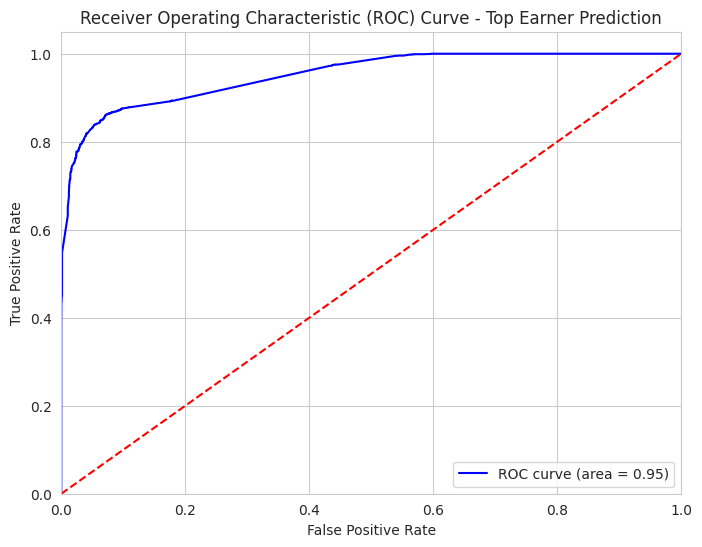

In [116]:
if len(np.unique(y_test)) > 1: # ROC AUC only makes sense for binary classification with both classes present
    print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_proba_test):.4f}")
    # Plot ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_test)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc_score(y_test, y_pred_proba_test):.2f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve - Top Earner Prediction')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()
else:
    print("ROC AUC score and curve not computed as only one class present in y_test.")
